In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.io.json import json_normalize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from scipy.stats import skew, kurtosis, entropy, iqr, median_abs_deviation
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from math import sqrt
import sklearn.metrics as metrics
import sklearn.metrics as sm
from sklearn.model_selection import GridSearchCV

In [2]:
def open_datos(url):
    with open(url, 'r') as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)
    return df


def find_signals(time_series):
    start_index = None
    max_abs_val = None
    signals = []
    
    for i, value in enumerate(time_series):
        if start_index is None and value <= -0.06:
            start_index = i
            max_abs_val = value
        elif start_index is not None:
            if value < max_abs_val:
                max_abs_val = value
            
            if value >= 0.03:
                signals.append((start_index, i, max_abs_val))
                start_index = None
                max_abs_val = None
    
    df = pd.DataFrame(signals, columns=['Start index', 'End index', 'Maximum Abs Value'])
    df["Duracion_Trade"]=df["End index"]-df["Start index"]
    return df

In [3]:
data=pd.read_csv("/Users/rogarciag/Desktop/AI_&_TRADING/ALGORITHMIC_TRADING/PRINCIPAL/NASINI/TRABAJOS_GENERAL/PROYECTO_TRADING/BASES_DE_DATOS/DATOS_CSV/AL30_COMPLETE_TASAS.csv")

In [4]:
time_series = pd.DataFrame(columns=['date','spread'])
# modifiique los nombres así era más claro

#APLICAR EXPONENTE HURST
data["SPREAD_COLOCAR_PLAZO_CERCANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)
data["SPREAD_COLOCAR_PLAZO_LEJANO"] = data["COLOCAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data["SPREAD_TOMAR_PLAZO_CERCANO"] =data["TOMAR_TASA_ABRIENDO_PLAZO_CERCANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100) 
data["SPREAD_TOMAR_PLAZO_LEJANO"] = data["TOMAR_TASA_ABRIENDO_PLAZO_LEJANO_TASA"] - (data["caucion_a_un_dia_ultimo_trade_tasa"] / 100)

data_general=data[["caucion_a_un_dia_ultimo_trade_tasa","SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

threshold_arbitrage=0

for index, row in data_general.iterrows():
    #Elegimos el mejor spread para colocar y tomar
    if  row["SPREAD_COLOCAR_PLAZO_CERCANO"] > row["SPREAD_COLOCAR_PLAZO_LEJANO"]:
         spread_colocar = row["SPREAD_COLOCAR_PLAZO_CERCANO"]
    else:
        spread_colocar = row["SPREAD_COLOCAR_PLAZO_LEJANO"]

    if row["SPREAD_TOMAR_PLAZO_CERCANO"] < row["SPREAD_TOMAR_PLAZO_LEJANO"]:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_CERCANO"]

    else:
        spread_tomar = row["SPREAD_TOMAR_PLAZO_LEJANO"]

    # CASO NO PASA NADA
    if row["SPREAD_COLOCAR_PLAZO_CERCANO"] < threshold_arbitrage and row["SPREAD_COLOCAR_PLAZO_LEJANO"] < threshold_arbitrage  and row["SPREAD_TOMAR_PLAZO_CERCANO"] > threshold_arbitrage and row["SPREAD_TOMAR_PLAZO_LEJANO"] > threshold_arbitrage:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)
        
    elif spread_colocar > 0 and spread_tomar < 0:

        if spread_colocar > -spread_tomar:
            
            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)
        
        else:

            time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)

    elif spread_colocar > 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_colocar]})],ignore_index=True)

    elif spread_tomar < 0:

        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[spread_tomar]})],ignore_index=True)
    else:
        time_series = pd.concat([time_series, pd.DataFrame({'date':[index],'spread':[0]})],ignore_index=True)

In [5]:
spread_final=time_series["spread"]
ts_not_spread=data_general=data[["SPREAD_COLOCAR_PLAZO_CERCANO","SPREAD_COLOCAR_PLAZO_LEJANO","SPREAD_TOMAR_PLAZO_CERCANO","SPREAD_TOMAR_PLAZO_LEJANO"]]

# MEDIAN DEVIATION FROM THE MEDIAN

In [6]:
import numpy as np

import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix

def mad(data):
    """
    Calculate the median deviation from the median (MDM) for a given set of data
    
    Parameters:
    data (array-like): The data for which MDM needs to be calculated
    
    Returns:
    The MDM of the data
    """
    median = np.median(data)
    abs_deviation = np.abs(data - median)
    
    return np.median(abs_deviation)


data = ts_not_spread
short_window = 10  # Define the short-term window
long_window = 60   # Define the long-term window

# Calculate the rolling mean absolute deviation for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)

data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)

data["SCORE"] = 0

# Compare the short-term and long-term mean absolute deviations
data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1



final_df=pd.DataFrame()
final_df["Total_Spread"]=spread_final
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,12
5,1565,1570,-0.399987,5,4
9,3507,3527,-0.357448,20,5
14,3683,3692,-0.241893,9,0
12,3669,3671,-0.212930,2,0
3,1551,1552,-0.211301,1,12
13,3672,3681,-0.199302,9,0
11,3658,3667,-0.196181,9,6
30,4934,4944,-0.167277,10,0
21,4765,4777,-0.152074,12,0


Mean absolute error = 2.45
Mean squared error = 11.89
Median absolute error = 1.43
Explain variance score = 0.29
R2 score = 0.29


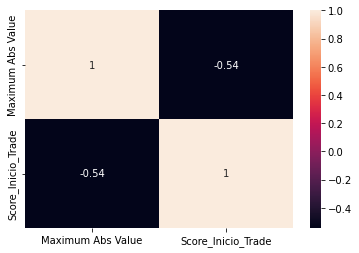

In [7]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

# GEOMETRIC STANDARD DEVIATION

In [8]:
def mad(data):
    """
    Calculate the geometric standard deviation (GSD) for a given set of data
    
    Parameters:
    data (array-like): The data for which GSD needs to be calculated
    
    Returns:
    The GSD of the data
    """
    log_data = np.log(data)
    log_mean = np.mean(log_data)
    log_std_dev = np.std(log_data)
    
    return np.exp(log_std_dev)

data = ts_not_spread
short_window = 10  # Define the short-term window
long_window = 60   # Define the long-term window

# Calculate the rolling mean absolute deviation for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)

data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)

data["SCORE"] = 0

# Compare the short-term and long-term mean absolute deviations
data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1



final_df=pd.DataFrame()
final_df["Total_Spread"]=spread_final
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter

,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,4
5,1565,1570,-0.399987,5,5
9,3507,3527,-0.357448,20,1
14,3683,3692,-0.241893,9,8
12,3669,3671,-0.212930,2,2
3,1551,1552,-0.211301,1,2
13,3672,3681,-0.199302,9,3
11,3658,3667,-0.196181,9,2
30,4934,4944,-0.167277,10,8
21,4765,4777,-0.152074,12,7


Mean absolute error = 2.34
Mean squared error = 8.33
Median absolute error = 2.4
Explain variance score = 0.0
R2 score = 0.0


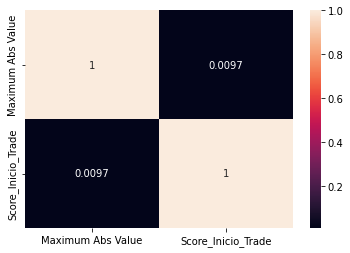

In [9]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

# Winsorized Variance

In [10]:
import numpy as np
import scipy.stats 

def mad(data, trim_percent=0.05):
    trimmed_data = scipy.stats.trimboth(data, trim_percent)
    mean = np.mean(trimmed_data)
    deviation = trimmed_data - mean
    winsorized_deviation = scipy.stats.mstats.winsorize(deviation, limits=trim_percent)
    return np.mean(np.square(winsorized_deviation))


data = ts_not_spread
short_window = 10  # Define the short-term window
long_window = 60   # Define the long-term window

# Calculate the rolling mean absolute deviation for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)

data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)

data["SCORE"] = 0

# Compare the short-term and long-term mean absolute deviations
data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1



final_df=pd.DataFrame()
final_df["Total_Spread"]=spread_final
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter


,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,12
5,1565,1570,-0.399987,5,10
9,3507,3527,-0.357448,20,8
14,3683,3692,-0.241893,9,9
12,3669,3671,-0.212930,2,4
3,1551,1552,-0.211301,1,12
13,3672,3681,-0.199302,9,3
11,3658,3667,-0.196181,9,8
30,4934,4944,-0.167277,10,0
21,4765,4777,-0.152074,12,1


Mean absolute error = 2.99
Mean squared error = 13.24
Median absolute error = 2.51
Explain variance score = 0.35
R2 score = 0.35


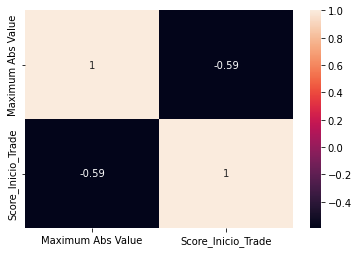

In [11]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))

# Robust Coefficient of Variation (RCV)

In [26]:
def mad(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    rcv = mad / median
    
    return rcv


data = ts_not_spread
short_window = 10  # Define the short-term window
long_window = 60   # Define the long-term window

# Calculate the rolling mean absolute deviation for each column
data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=short_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=short_window).apply(mad)

data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_COLOCAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_CERCANO"].rolling(window=long_window).apply(mad)
data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"] = data["SPREAD_TOMAR_PLAZO_LEJANO"].rolling(window=long_window).apply(mad)

data["SCORE"] = 0

# Compare the short-term and long-term mean absolute deviations
data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] >= data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1

data.loc[data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_COLOCAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.50), "SCORE"] += 1

data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.65), "SCORE"] += 1


data.loc[data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_CERCANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1
data.loc[data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_SHORT"] > data["SPREAD_TOMAR_PLAZO_LEJANO_MAD_LONG"].quantile(0.80), "SCORE"] += 1



final_df=pd.DataFrame()
final_df["Total_Spread"]=spread_final
final_df["Total_Score_Parametro_1_negativo"]=data["SCORE"]

time_series = final_df["Total_Spread"]
result = find_signals(time_series)

df_1 = result
df_2 = final_df["Total_Score_Parametro_1_negativo"]
indices = df_1["Start index"].values
df_score_spread = df_2.loc[indices]

df_score_filtrado=pd.DataFrame(df_score_spread)
result["Score_Inicio_Trade"]=df_score_filtrado["Total_Score_Parametro_1_negativo"].values

result_sorted = result.sort_values('Maximum Abs Value', ascending=True)
result_sorted.dropna(inplace=True)

result_filter=result_sorted[result_sorted["Duracion_Trade"]<50]
result_filter



,Start index,End index,Maximum Abs Value,Duracion_Trade,Score_Inicio_Trade
4,1554,1563,-0.871009,9,6
5,1565,1570,-0.399987,5,8
9,3507,3527,-0.357448,20,3
14,3683,3692,-0.241893,9,0
12,3669,3671,-0.212930,2,3
3,1551,1552,-0.211301,1,6
13,3672,3681,-0.199302,9,0
11,3658,3667,-0.196181,9,1
30,4934,4944,-0.167277,10,6
21,4765,4777,-0.152074,12,3


Mean absolute error = 3.2
Mean squared error = 13.65
Median absolute error = 2.68
Explain variance score = 0.0
R2 score = 0.0


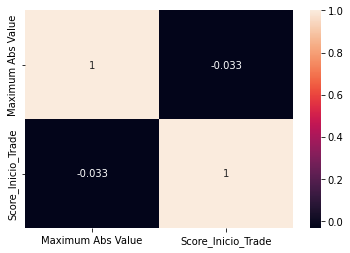

In [27]:
sns.heatmap(result_filter[["Maximum Abs Value","Score_Inicio_Trade"]].corr(),annot=True)
x=result_filter[['Maximum Abs Value']]
y=result_filter['Score_Inicio_Trade']

sc=StandardScaler().fit(x)
x_sc=sc.transform(x)

lm=LinearRegression()
lm.fit(x_sc, y)
predictions=lm.predict(x_sc)

print("Mean absolute error =", round(sm.mean_absolute_error(y, predictions), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y, predictions), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y, predictions), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y, predictions), 2)) 
print("R2 score =", round(sm.r2_score(y, predictions), 2))